## Installation

In [ ]:
#INSTALLING PYTORCH
#For cpu only
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [9]:
!pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'
!pip install pandas
!pip install transformers
!pip install -U scikit-learn scipy matplotlib
!pip install datasets
!pip install accelerate -U
!pip install scikit-learn
!pip install wandb
# if got error: 
# ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`
#Rememeber to restart the kernel after updagrade
# !pip install accelerate --upgrade 

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /tmp/pip-req-build-n089rgpd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-n089rgpd
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578
  Resolved https://github.com/facebookresearch/detectron2.git to commit 82a57ce0b70057685962b352535147d9a8118578
  Preparing metadata (setup.py) ... done
  Using cached datasets-2.19.1-py3-none-any.whl.metadata (19 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
Using cached datasets-2.19.1-py3-none-any.whl (542 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 93.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00

## Model
Reference: 
- https://colab.research.google.com/drive/1bLGxKdldwqnMVA5x4neY7-l_8fKGWQYI?usp=sharing#scrollTo=7-5rqN-vtlkq
- https://github.com/Ikea-179/Hateful-Meme-Detection/blob/main/VisualBERT.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import torch, torchvision
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from copy import deepcopy
import os
from transformers import TrainingArguments, Trainer
from torch.utils.data import DataLoader
from transformers import BertTokenizer, VisualBertForPreTraining, AutoTokenizer
import time
import wandb

### Dataset

In [3]:
data_path='/scratch/izar/cchang/EE559/data/hateful_memes/train_df_wQuery_.jsonl'
import pandas as pd
img_data = pd.read_json(path_or_buf=data_path, lines=True).to_dict(orient='records')
print(len(img_data))
print(img_data[0].keys())

8500
dict_keys(['id', 'img', 'label', 'text', 'query_1'])


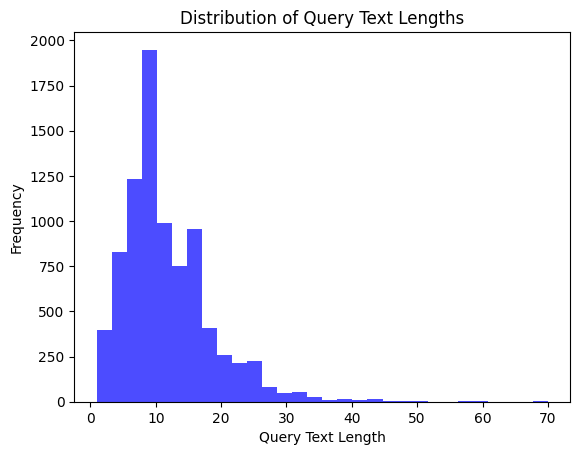

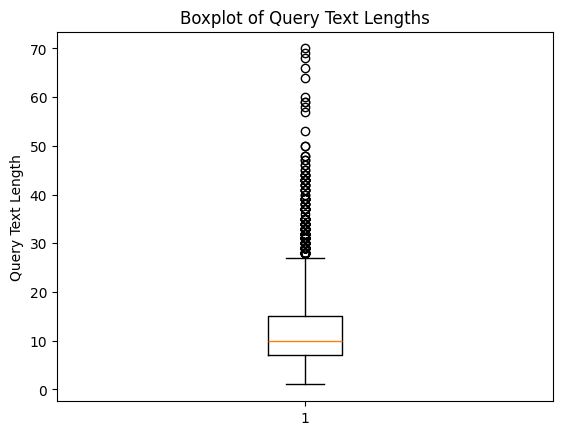

Max length:  70
Min length:  1
Average length:  11.742588235294118
Standard deviation:  6.8770212128729264


In [5]:
import matplotlib.pyplot as plt
train_df = pd.read_json(data_path, lines=True)
# Calculate the lengths
query_lengths = train_df['text'].apply(lambda n: len(n.split()))

# Create a histogram
plt.hist(query_lengths, bins=30, alpha=0.7, color='b')

# Add title and labels
plt.title('Distribution of Query Text Lengths')
plt.xlabel('Query Text Length')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Create a boxplot
plt.boxplot(query_lengths)
plt.title('Boxplot of Query Text Lengths')
plt.ylabel('Query Text Length')
plt.show()

# Print statistics
print("Max length: ", query_lengths.max())
print("Min length: ", query_lengths.min())
print("Average length: ", query_lengths.mean())
print("Standard deviation: ", query_lengths.std())

In [12]:
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset

class HatefulMemesData(Dataset):
    def __init__(self, df,img_dir, tokenizer, sequence_length,caption_sequence_length=512, visual_embed_model='vit', print_text=False, visual_embeder_detecron2=None, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):         
        self.device=device
        self.sequence_length = sequence_length
        self.caption_sequence_length= caption_sequence_length
        self.tokenizer = tokenizer
        self.print_text = print_text
        self.dataset = pd.read_json(path_or_buf=df, lines=True).to_dict(orient='records')
        self.img_dir = img_dir
        self.visual_embed_model = visual_embed_model
        self.feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        self.feature_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to(self.device)
        if self.visual_embed_model=='detectron2' and visual_embeder_detecron2 is not None:
            self.visualembedder=visual_embeder_detecron2

    def __len__(self):
        return len(self.dataset)


    def tokenize_data(self, example):
   
        idx = example['id']
        # idx = [idx] if isinstance(idx, str) else idx
        
        encoded_dict = self.tokenizer(example['text'], padding='max_length', max_length=self.sequence_length, truncation=True, return_tensors='pt')
        tokens = encoded_dict['input_ids']
        token_type_ids = encoded_dict['token_type_ids']
        attn_mask = encoded_dict['attention_mask']
        
        captioning_encode_dict=self.tokenizer(example['query_1'], padding='max_length', max_length=self.caption_sequence_length,truncation=True, return_tensors='pt')
        caption_token=captioning_encode_dict['input_ids']
        caption_token_type_ids=captioning_encode_dict['token_type_ids']
        caption_attn_mask=captioning_encode_dict['attention_mask']

        targets = torch.tensor(example['label']).type(torch.int64)

        ## Get Visual Embeddings
        try:
            if self.visual_embed_model=='vit':
                #TODO: make it work
                img = example['img'].split('/')[-1]
                img = Image.open(os.path.join(self.img_dir , img))
                img = np.array(img)
                img = img[...,:3]
                inputs = self.feature_extractor(images=img, return_tensors="pt")
                outputs = self.feature_model(**inputs.to(device))
                visual_embeds = outputs.last_hidden_state
                visual_embeds = visual_embeds.cpu() #
            elif self.visual_embed_model=='detectron2':
                visual_embeds = self.visualembedder.visual_embeds_detectron2([cv2.imread(os.path.join(self.img_dir, example['img'].split('/')[-1]))])[0]

        except:
            # print("Error with Id: ", idx)
            if self.visual_embed_model=='vit':
                visual_embeds = np.zeros(shape=(197, 768), dtype=float)
            elif self.visual_embed_model=='detectron2':
                visual_embeds = np.zeros(shape=(100, 1024), dtype=float)

        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.int64)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.int64)

        inputs={"input_ids": tokens.squeeze(),
            "attention_mask": attn_mask.squeeze(),
            "token_type_ids": token_type_ids.squeeze(),
            "visual_embeds": visual_embeds.squeeze(),
            "visual_token_type_ids": visual_token_type_ids.squeeze(),
            "visual_attention_mask": visual_attention_mask.squeeze(),
            "label": targets.squeeze(),
            "caption_input_ids": caption_token.squeeze(),
            "caption_attention_mask": caption_attn_mask.squeeze(),
            "caption_token_type_ids": caption_token_type_ids.squeeze()
        }
        
        return inputs
  
    def __getitem__(self, index):
        inputs = self.tokenize_data(self.dataset[index])
        
        if self.print_text:
            for k in inputs.keys():
                print(k, inputs[k].shape, inputs[k].dtype)

        return inputs

## Fine-tune Model

### Model Architecture (with weight ensemble fusion)

In [13]:
from transformers import BertTokenizer, VisualBertModel, TrainingArguments, Trainer, VisualBertConfig
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from transformers import BertTokenizer, BertModel
class VisualBERTClassifier(torch.nn.Module):
    def __init__(self, visual_embedder='vit'):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(VisualBERTClassifier, self).__init__()
        configuration = VisualBertConfig.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre',
                                                hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
        self.visualbert = VisualBertModel.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre', config=configuration)
        self.bertmodel = BertModel.from_pretrained('bert-base-uncased')
        for param in self.visualbert.parameters():
            param.requires_grad = False
        for param in self.bertmodel.parameters():
            param.requires_grad = False

        if visual_embedder=='vit':
            self.embed_cls = nn.Linear(768, 1024)
        elif visual_embedder=='detectron2':
            self.embed_cls = nn.Linear(1024, 1024)
        self.num_labels = 2
        self.dropout = nn.Dropout(0.3)
        self.alpha = nn.Parameter(torch.tensor(0.5), requires_grad=True)  # Initial value of alpha
        self.cls= nn.Sequential(
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(768, 348),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(348, 192),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(192, self.num_labels)
        )
        # TODO: Calculate the weights for the loss function and weight balanced loss
        # nSamples = [5178, 2849]
        # normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
        # self.loss_fct = CrossEntropyLoss(weight=torch.FloatTensor(normedWeights))
        self.loss_fct = CrossEntropyLoss()
        
    
    def forward(self, input_ids, attention_mask, token_type_ids, visual_embeds, visual_attention_mask,
                visual_token_type_ids, labels,caption_input_ids, caption_attention_mask, caption_token_type_ids):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        
        visual_embeds_cls = self.embed_cls(visual_embeds)
        with torch.no_grad():
            outputs = self.visualbert(
                    input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    visual_embeds=visual_embeds_cls,
                    visual_attention_mask=visual_attention_mask,
                    visual_token_type_ids=visual_token_type_ids,
                )
        
        visualbert_embedding = outputs[1] # output is a context vector of 768 dimensions

        
        with torch.no_grad():
            caption_outputs = self.bertmodel(caption_input_ids, attention_mask=caption_attention_mask, token_type_ids=caption_token_type_ids)
                
        # Get the embeddings of the [CLS] token
        caption_embeddings = caption_outputs.last_hidden_state[:,0,:] # output is a context vector of 768 dimensions

        # funsion model: weight ensenble of the two embeddings: alpha*visualbert_embedding + (1-alpha)*caption_embeddings 
        fused_embedding = self.alpha * self.dropout(visualbert_embedding) + (1-self.alpha) * self.dropout(caption_embeddings)

        logits = self.cls(fused_embedding)
        ##
        
        reshaped_logits = logits.view(-1, self.num_labels)
        loss = self.loss_fct(reshaped_logits, labels.view(-1))
      
        return loss, reshaped_logits

##### To check model architecture and shape for each layer

In [20]:
model=VisualBERTClassifier()
for layer_name, params in model.named_parameters():
    print(layer_name, params.shape)

alpha torch.Size([])
visualbert.embeddings.word_embeddings.weight torch.Size([30522, 768])
visualbert.embeddings.position_embeddings.weight torch.Size([512, 768])
visualbert.embeddings.token_type_embeddings.weight torch.Size([2, 768])
visualbert.embeddings.LayerNorm.weight torch.Size([768])
visualbert.embeddings.LayerNorm.bias torch.Size([768])
visualbert.embeddings.visual_token_type_embeddings.weight torch.Size([2, 768])
visualbert.embeddings.visual_position_embeddings.weight torch.Size([512, 768])
visualbert.embeddings.visual_projection.weight torch.Size([768, 1024])
visualbert.embeddings.visual_projection.bias torch.Size([768])
visualbert.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
visualbert.encoder.layer.0.attention.self.query.bias torch.Size([768])
visualbert.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
visualbert.encoder.layer.0.attention.self.key.bias torch.Size([768])
visualbert.encoder.layer.0.attention.self.value.weight torch.Size([

In [14]:
from sklearn.metrics import roc_auc_score
from datasets import load_metric
acc_metric = load_metric('accuracy')
f1_metric = load_metric('f1')
precision_metric = load_metric('precision')
recall_metric = load_metric('recall')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = acc_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels)
    recall = recall_metric.compute(predictions=predictions, references=labels)
    auc_score = roc_auc_score(labels, predictions)
    return {"accuracy": acc['accuracy'], "auroc": auc_score,'f1':f1['f1'],'precision':precision['precision'],'recall':recall['recall']} 

/home/jessica/anaconda3/envs/dl_project_310/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/jessica/anaconda3/envs/dl_project_310/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_c

##### Define training hyperparameters and all model used

In [11]:
with open("/home/cchang/wandb.key", "r") as f:
        wandb_key = f.read().strip()
        
wandb.login(key=wandb_key)
wandb.init(
    project="HatefulMemes",
)

data_folder_path='/scratch/izar/cchang/EE559'

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_data_path=os.path.join(data_folder_path, '/data/hateful_memes/train_df_wQuery_.jsonl')
validation_data_path=os.path.join(data_folder_path, '/data/hateful_memes/dev_seen_df_wQuery_.jsonl')
img_inpainted_dir=os.path.join(data_folder_path, '/data/hateful_memes/img_inpainted')
visual_embed_model='vit'
## For visual_embed_model='detectron2'
# cfg_path="COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
# MIN_BOXES=10 
# MAX_BOXES=100
# visualembedder_detectron2=VisualEmbedder(cfg_path=cfg_path, min_boxes=MIN_BOXES, max_boxes=MAX_BOXES)
##
# output_dir=os.path.join('/scratch/izar/cchang/EE559/model-checkpoint', f'hatefulmemcladdifier_weightensemble_{visual_embed_model}_{time.strftime("%Y%m%d%H%M")}')
output_dir=os.path.join('model-checkpoint', f'hatefulmemcladdifier_weightensemble_{visual_embed_model}_{time.strftime("%Y%m%d%H%M")}')

batch_size = 1
seq_len = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisualBERTClassifier()
model = model.to(device)

args = TrainingArguments(
    output_dir = output_dir,
    seed = 110, 
    save_strategy="steps",
    evaluation_strategy = "steps",
    learning_rate=1e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs= 5,
    weight_decay=0.05,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="auroc",
    fp16 = False,
    save_steps=100,
    eval_steps=50,
    logging_steps=50,
    report_to="wandb"
)

trainer = Trainer(
    model,
    args,
    train_dataset = HatefulMemesData(train_data_path, img_inpainted_dir, tokenizer, sequence_length=seq_len, visual_embed_model=visual_embed_model,device=device),
    eval_dataset =  HatefulMemesData(validation_data_path, img_inpainted_dir,tokenizer, sequence_length=seq_len, visual_embed_model=visual_embed_model,device=device),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/home/jessica/anaconda3/envs/dl_project_310/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jessica/anaconda3/envs/dl_project_310/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/jessica/anaconda3/envs/dl_project_310/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jessica/anaconda3/envs/dl_project_310/lib/python3.10/site-packages/tr

##### Train + evaluation on validation state

In [12]:
trainer.train()

  0%|          | 1/42500 [00:01<22:00:33,  1.86s/it]

visualbert_embedding torch.Size([1, 768]) torch.float32
caption_embeddings torch.Size([1, 768]) torch.float32


  0%|          | 2/42500 [00:03<20:43:29,  1.76s/it]

visualbert_embedding torch.Size([1, 768]) torch.float32
caption_embeddings torch.Size([1, 768]) torch.float32


  0%|          | 3/42500 [00:05<20:41:49,  1.75s/it]

visualbert_embedding torch.Size([1, 768]) torch.float32
caption_embeddings torch.Size([1, 768]) torch.float32


KeyboardInterrupt: 

##### Inference on test dataset

In [ ]:
##TODO: Inference and evaluate on test data